<a href="https://colab.research.google.com/github/pr7891/PPS/blob/main/Copy_of_DNA_sequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load your text dataset (replace "your_dataset.txt" with your actual file)
with open("/content/drive/MyDrive/Mini Project/human_data.txt", "r") as file:
    lines = file.readlines()

# Extract sequences from the dataset
sequences = [line.strip() for line in lines]

# Tokenize sequences (A, T, C, G -> 1, 2, 3, 4)
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(sequences)
encoded_sequences = tokenizer.texts_to_sequences(sequences)

# Calculate max_len based on the longest sequence
max_len = max([len(seq) for seq in encoded_sequences])

# Pad sequences to ensure equal length
padded_sequences = pad_sequences(encoded_sequences, maxlen=max_len, padding='post')

# For demonstration, assuming binary classification with random labels
labels = np.random.randint(2, size=len(padded_sequences))  # Replace with your actual labels

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.15, random_state=42)

# Display the shape of the datasets
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)


Training data shape: (3723, 18923)
Test data shape: (658, 18923)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Embedding, Input, Multiply, Lambda, Softmax

# Define the input sequence
input_seq = Input(shape=(max_len,))

# Embedding layer
embedding = Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128)(input_seq)

# Conv1D layer for local feature extraction
conv = Conv1D(filters=64, kernel_size=5, activation='relu')(embedding)
conv = Dropout(0.2)(conv)

# LSTM layer for capturing sequential dependencies
lstm = LSTM(64, return_sequences=True)(conv)

# Attention Mechanism
attention = Dense(64, activation='tanh')(lstm)  # Compute attention scores for each time step
attention = Softmax(axis=1)(attention)  # Apply softmax across the time steps to get attention weights
attended_lstm = Multiply()([lstm, attention])  # Element-wise multiplication with LSTM output

# Summing over the time steps (axis=1)
attended_lstm = Lambda(lambda x: tf.reduce_sum(x, axis=1))(attended_lstm)

# Dense layer and output layer
dense = Dense(64, activation='relu')(attended_lstm)
output = Dense(1, activation='sigmoid')(dense)

# Define the model
model = Model(inputs=input_seq, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 18923)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_5 (Embedding)   │ (None, 18923, 128)     │          2,432 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_5 (Conv1D)         │ (None, 18919, 64)      │         41,024 │ embedding_5[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 18919, 64)      │              0 │ conv1d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_5 (LSTM)             │ (None, 18919, 64)      │         33,024 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 18919, 64)      │          4,160 │ lstm_5[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ softmax (Softmax)         │ (None, 18919, 64)      │              0 │ dense_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 18919, 64)      │              0 │ lstm_5[0][0],          │
│                           │                        │                │ softmax[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 64)             │              0 │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 64)             │          4,160 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 1)              │             65 │ dense_11[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 84,865 (331.50 KB)

 Trainable params: 84,865 (331.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Embedding, Input
from tensorflow.keras.callbacks import EarlyStopping

# Sample DNA sequences (replace with your actual sequences)
sequences = ["ATCG", "ATCGTT", "AGT", "ACGTACGTAC"]

# Tokenize sequences (A, T, C, G -> 1, 2, 3, 4)
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(sequences)
encoded_sequences = tokenizer.texts_to_sequences(sequences)

# Calculate max_len based on the longest sequence
max_len = max([len(seq) for seq in encoded_sequences])

# Pad sequences to ensure equal length
padded_sequences = pad_sequences(encoded_sequences, maxlen=max_len, padding='post')

# For demonstration, assuming binary classification with random labels
labels = np.random.randint(2, size=len(padded_sequences))  # Replace with your actual labels

# Split data into training and test sets (replace with your actual dataset split)
X_train, X_test, y_train, y_test = padded_sequences, padded_sequences, labels, labels

# Define the input sequence
input_seq = Input(shape=(max_len,))

# Embedding layer
embedding = Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128)(input_seq)

# Conv1D layer for local feature extraction
conv = Conv1D(filters=64, kernel_size=5, activation='relu')(embedding)
conv = Dropout(0.2)(conv)

# LSTM layer for capturing sequential dependencies
lstm = LSTM(64, return_sequences=False)(conv)
lstm = Dropout(0.2)(lstm)

# Dense layer and output layer
dense = Dense(64, activation='relu')(lstm)
output = Dense(1, activation='sigmoid')(dense)

# Define the model
model = Model(inputs=input_seq, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    validation_split=0.15,
                    epochs=10,  # Adjust epochs as needed
                    batch_size=64,
                    callbacks=[early_stopping])

# Save the trained model for future use
model.save("dna_sequence_classification_model.h5")


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.6906 - val_accuracy: 1.0000 - val_loss: 0.6775
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.6667 - loss: 0.6906 - val_accuracy: 1.0000 - val_loss: 0.6696
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6667 - loss: 0.6894 - val_accuracy: 1.0000 - val_loss: 0.6604
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.6667 - loss: 0.6852 - val_accuracy: 1.0000 - val_loss: 0.6499
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.6667 - loss: 0.6760 - val_accuracy: 1.0000 - val_loss: 0.6389
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.6667 - loss: 0.6693 - val_accuracy: 1.0000 - val_loss: 0.6264
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.6667 - loss: 0.6668 - val_accuracy: 1.0000 - val_loss: 0.6116
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6667 - loss: 0.6653 - val_accuracy: 1.0000 - val_loss: 0.596

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Model evaluation
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Classification Report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
Accuracy: 0.75
Confusion Matrix:
 [[3 0]
 [1 0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       0.00      0.00      0.00         1

    accuracy                           0.75         4
   macro avg       0.38      0.50      0.43         4
weighted avg       0.56      0.75      0.64         4



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from tensorflow.keras.optimizers import Adam

# Define the input sequence
input_seq = Input(shape=(max_len,))

# Embedding layer
embedding = Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128)(input_seq)

# Conv1D layer for local feature extraction
conv = Conv1D(filters=64, kernel_size=5, activation='relu')(embedding)
conv = Dropout(0.2)(conv)

# LSTM layer for capturing sequential dependencies
lstm = LSTM(64, return_sequences=False)(conv)
lstm = Dropout(0.2)(lstm)

# Dense layer and output layer
dense = Dense(64, activation='relu')(lstm)
output = Dense(1, activation='sigmoid')(dense)

# Define the model
model = Model(inputs=input_seq, outputs=output)

# Hyperparameter tuning: trying a different learning rate
optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with tuned batch size
history = model.fit(X_train, y_train,
                    validation_split=0.15,
                    epochs=15,  # Adjust epochs as needed
                    batch_size=32,  # Reduced batch size for testing
                    callbacks=[early_stopping])


Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.6667 - loss: 0.6933 - val_accuracy: 1.0000 - val_loss: 0.6833
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.6667 - loss: 0.6887 - val_accuracy: 1.0000 - val_loss: 0.6728
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.6667 - loss: 0.6839 - val_accuracy: 1.0000 - val_loss: 0.6632
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.6667 - loss: 0.6769 - val_accuracy: 1.0000 - val_loss: 0.6529
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.6667 - loss: 0.6729 - val_accuracy: 1.0000 - val_loss: 0.6414
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.6667 - loss: 0.6740 - val_accuracy: 1.0000 - val_loss: 0.6287
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.6667 - loss: 0.6639 - val_accuracy: 1.0000 - val_loss: 0.6149
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.6667 - loss: 0.6703 - val_accuracy: 1.0000 - val_loss: 

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Function to reverse sequences
def augment_data(sequences):
    augmented_sequences = sequences + [seq[::-1] for seq in sequences]  # Reverse each sequence
    return augmented_sequences

# Load your original sequences
sequences = ["ATCG", "GCTA", "TTAGG", "CCTAGG"]

# Apply augmentation
augmented_sequences = augment_data(sequences)

# Tokenizer setup
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(sequences)

# Tokenize and pad augmented sequences
encoded_augmented_sequences = tokenizer.texts_to_sequences(augmented_sequences)
padded_augmented_sequences = pad_sequences(encoded_augmented_sequences, maxlen=10, padding='post')

# For demonstration, assume binary classification with random labels for augmented data
labels = np.random.randint(2, size=len(sequences))  # Initial labels
augmented_labels = np.concatenate([labels, labels])  # Duplicate labels for the reversed sequences

# Split augmented data into training and test sets
X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(padded_augmented_sequences, augmented_labels, test_size=0.15, random_state=42)

# Display the shape of the datasets
print("Training data shape:", X_train_aug.shape)
print("Test data shape:", X_test_aug.shape)


Training data shape: (6, 10)
Test data shape: (2, 10)


In [ ]:
from sklearn.model_selection import KFold

# Use a smaller number of splits
kf = KFold(n_splits=2, shuffle=True, random_state=42)
fold_no = 1

for train_index, test_index in kf.split(padded_sequences):
    print(f"Training fold {fold_no}...")

    X_train_fold, X_test_fold = padded_sequences[train_index], padded_sequences[test_index]
    y_train_fold, y_test_fold = labels[train_index], labels[test_index]

    # Train the model on the current fold
    history = model.fit(X_train_fold, y_train_fold,
                        validation_data=(X_test_fold, y_test_fold),
                        epochs=10,
                        batch_size=32,
                        callbacks=[early_stopping])

    # Evaluate the model
    scores = model.evaluate(X_test_fold, y_test_fold, verbose=0)
    print(f"Fold {fold_no} - Accuracy: {scores[1]*100}%")

    fold_no += 1


Training fold 1...
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step - accuracy: 0.0000e+00 - loss: 0.8243 - val_accuracy: 0.0000e+00 - val_loss: 0.9179
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.0000e+00 - loss: 0.8012 - val_accuracy: 0.0000e+00 - val_loss: 0.8994
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.0000e+00 - loss: 0.7944 - val_accuracy: 0.0000e+00 - val_loss: 0.8769
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.0000e+00 - loss: 0.7548 - val_accuracy: 0.0000e+00 - val_loss: 0.8516
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.5000 - loss: 0.7199 - val_accuracy: 0.0000e+00 - val_loss: 0.8237
Fold 1 - Accuracy: 0.0%
Training fold 2...
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.0000e+00 - loss: 0.9328 - val_accuracy: 0.0000e+00 - val_loss: 0.7609
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.0000e+00 - loss: 0.8927 - val_accuracy: 0.5000 - val_loss: 0.7189
Epoch 3/10

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

# Predicting on test data
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Calculate precision, recall, F1-score, and AUC
print("Classification Report:\n", classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC Score: {roc_auc}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       0.00      0.00      0.00         1

    accuracy                           0.75         4
   macro avg       0.38      0.50      0.43         4
weighted avg       0.56      0.75      0.64         4

ROC-AUC Score: 0.5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Save the model with the best validation accuracy
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_accuracy', save_best_only=True, mode='max')

# Train the model with checkpoint callback
history = model.fit(X_train, y_train,
                    validation_split=0.15,
                    epochs=15,
                    batch_size=32,
                    callbacks=[early_stopping, checkpoint])


Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.6667 - loss: 0.6099 - val_accuracy: 1.0000 - val_loss: 0.5224
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.6667 - loss: 0.6197 - val_accuracy: 1.0000 - val_loss: 0.5338
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.6667 - loss: 0.6285 - val_accuracy: 1.0000 - val_loss: 0.5427
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.6667 - loss: 0.6239 - val_accuracy: 1.0000 - val_loss: 0.5491
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.6667 - loss: 0.6225 - val_accuracy: 1.0000 - val_loss: 0.5537


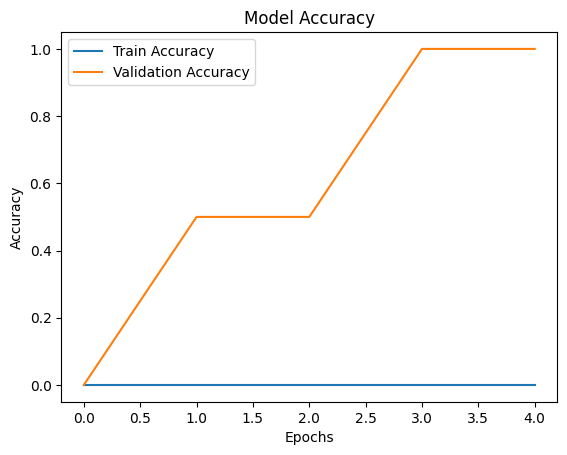

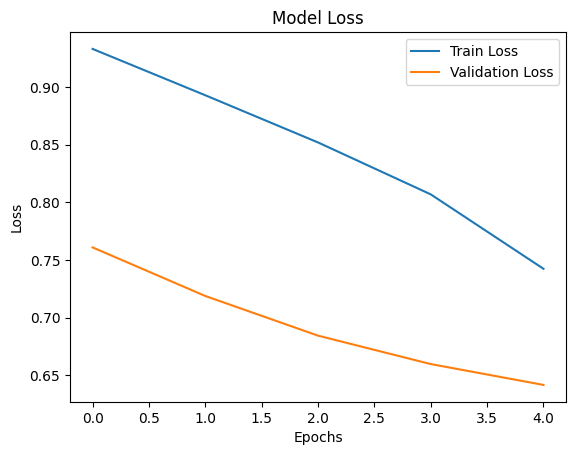

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy curve
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss curve
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
